In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest,f_classif, VarianceThreshold
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestClassifier
import pickle

In [2]:
with open('../data/processed/X_train', 'rb') as f:
    X_train = pickle.load(f)

with open('../data/processed/X_test', 'rb') as f:
    X_test = pickle.load(f)

with open('../data/processed/y_train', 'rb') as f:
    y_train = pickle.load(f)

with open('../data/processed/y_test', 'rb') as f:
    y_test = pickle.load(f)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(71371, 65)
(17843, 65)
(71371,)
(17843,)


In [3]:
numerical_columns = ['Census_ProcessorCoreCount',
                 'Census_PrimaryDiskTotalCapacity',
                 'Census_SystemVolumeTotalCapacity',
                 'Census_TotalPhysicalRAM',
                 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                 'Census_InternalPrimaryDisplayResolutionHorizontal',
                 'Census_InternalPrimaryDisplayResolutionVertical',
                 'Census_InternalBatteryNumberOfCharges']
rank_columns = [col for col in X_train.columns if 'encoded' in col]
numerical_columns = numerical_columns + rank_columns

binary_columns = [col for col in X_train.columns.tolist() if X_train[col].nunique() <= 2 if X_train[col].dtypes != 'O']

categorical_columns = X_train.select_dtypes('object').columns.tolist()
cat_num_columns = [col for col in X_train.columns.tolist() if col not in numerical_columns
              if col not in binary_columns if col not in categorical_columns]
tot_columns = numerical_columns + binary_columns + categorical_columns + cat_num_columns
len(tot_columns)

65

In [4]:
len(numerical_columns), len(binary_columns), len(categorical_columns), len(cat_num_columns), len(numerical_columns)+ len(binary_columns) + len(categorical_columns) + len(cat_num_columns)

(32, 9, 17, 7, 65)

In [5]:
y_train.mean(), y_test.mean()

(0.5005114121982318, 0.5026621083898447)

In [6]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer()

# Preprocessing for binary data
binary_transformer = SimpleImputer()

# Preprocessing for categorical data encoded as numerical ID's
categorical_num_transformer = SimpleImputer()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('bin', binary_transformer, binary_columns),
        ('cat_num', categorical_num_transformer, cat_num_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

In [7]:
# Define model
rf_clf = RandomForestClassifier(random_state = 42)
VarThresh = VarianceThreshold()
#selector = SelectKBest(f_classif)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('VarThresh', VarThresh),
                              #('selector', selector),
                              ('classifier', rf_clf)
                             ])


n_estimators = [500, 1000, 1500, 2000]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth.append(None)
min_samples_split = [3, 5, 7, 10, 15, 20, 25]
min_samples_leaf = [2, 3, 5, 7, 10, 15, 20, 25]
#bootstrap = [True, False]

parameters = {#'selector__k': [50, 70, 90, 110, 130],
              'preprocessor__num__strategy': ['mean', 'median', 'constant'],
              'preprocessor__bin__strategy': ['most_frequent', 'constant'],
              'preprocessor__cat_num__strategy': ['most_frequent', 'constant'],
              'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
              'classifier__n_estimators': n_estimators,
              'classifier__max_features' : max_features,
              'classifier__max_depth': max_depth,
              'classifier__min_samples_split': min_samples_split,
              'classifier__min_samples_leaf': min_samples_leaf,
              #'classifier__bootstrap': bootstrap
}

# Grid search
search = RandomizedSearchCV(estimator=my_pipeline, 
                             param_distributions=parameters,
                             n_iter = 10,
                             cv=5,
                             scoring = 'roc_auc',
                             return_train_score=True,
                             #n_jobs = -1,
                             verbose=3)

# Preprocessing of training data, fit model 
search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END classifier__max_depth=14, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=20, classifier__n_estimators=500, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=constant, preprocessor__num__strategy=median;, score=(train=0.822, test=0.693) total time=  51.6s
[CV 2/5] END classifier__max_depth=14, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=20, classifier__n_estimators=500, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=constant, preprocessor__num__strategy=median;, score=(train=0.823, test=0.692) total time=  51.3s
[CV 3/5] END classifier__max_depth=14, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=20, classifier__n_estimators=500, p

[CV 3/5] END classifier__max_depth=12, classifier__max_features=sqrt, classifier__min_samples_leaf=25, classifier__min_samples_split=25, classifier__n_estimators=2000, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=constant, preprocessor__num__strategy=median;, score=(train=0.744, test=0.686) total time= 2.8min
[CV 4/5] END classifier__max_depth=12, classifier__max_features=sqrt, classifier__min_samples_leaf=25, classifier__min_samples_split=25, classifier__n_estimators=2000, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=constant, preprocessor__num__strategy=median;, score=(train=0.743, test=0.698) total time= 2.8min
[CV 5/5] END classifier__max_depth=12, classifier__max_features=sqrt, classifier__min_samples_leaf=25, classifier__min_samples_split=25, classifier__n_estimators=2000, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__

[CV 4/5] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=3, classifier__n_estimators=1500, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=median;, score=(train=0.935, test=0.702) total time= 3.2min
[CV 5/5] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=3, classifier__n_estimators=1500, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=median;, score=(train=0.935, test=0.692) total time= 3.1min
[CV 1/5] END classifier__max_depth=None, classifier__max_features=auto, classifier__min_samples_leaf=10, classifier__min_samples_split=15, classifier__n_estimators=1000, preprocessor__bin__strategy=most_frequ

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(),
                                                                               ['Census_ProcessorCoreCount',
                                                                                'Census_PrimaryDiskTotalCapacity',
                                                                                'Census_SystemVolumeTotalCapacity',
                                                                                'Census_TotalPhysicalRAM',
                                                                                'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                                                'Census_InternalPrimaryDisplayResolutionHorizontal',
                  

In [8]:
# optimized model
opt_rf_clf = search.best_estimator_
search.best_params_

{'preprocessor__num__strategy': 'median',
 'preprocessor__cat_num__strategy': 'most_frequent',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__n_estimators': 1500,
 'classifier__min_samples_split': 3,
 'classifier__min_samples_leaf': 5,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 20}

In [9]:
from sklearn.metrics import roc_auc_score

# Predictions
y_pred_train = opt_rf_clf.predict(X_train)
y_pred_test = opt_rf_clf.predict(X_test)

print('Train Set roc auc:', roc_auc_score(y_train, y_pred_train))
print('Test Set roc auc:', roc_auc_score(y_test, y_pred_test))

Train Set roc auc: 0.837112112617583
Test Set roc auc: 0.6387664314312491


In [10]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.63      0.64      0.64      8874
           1       0.64      0.63      0.64      8969

    accuracy                           0.64     17843
   macro avg       0.64      0.64      0.64     17843
weighted avg       0.64      0.64      0.64     17843



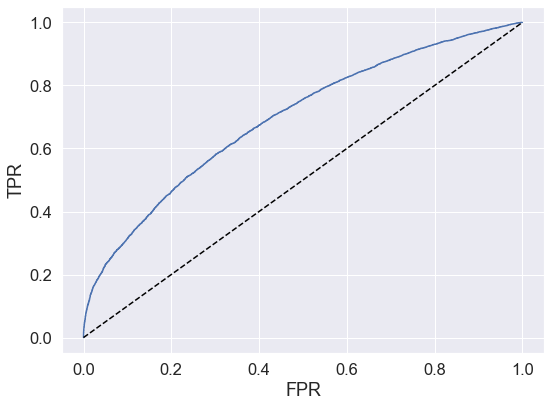

In [11]:
# plot ROC_AUC
import matplotlib.pyplot as plt 
import matplotlib as mpl 
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(font_scale=1.5)

from sklearn import metrics

y_pred_proba_test = opt_rf_clf.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_test[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--', color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.tight_layout()

Text(0.5, 1.0, 'Confusion matrix')

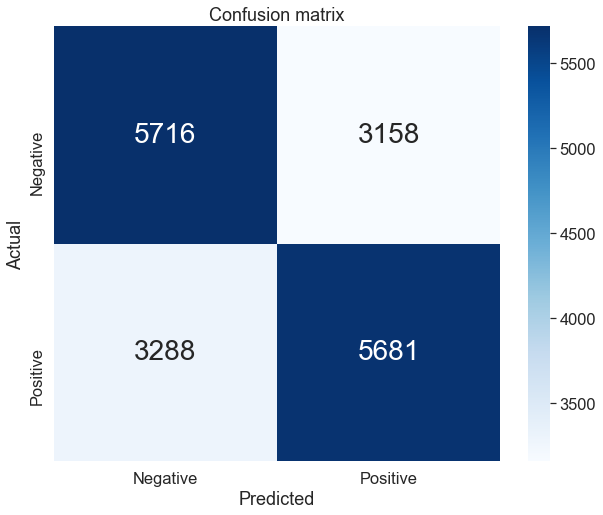

In [12]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_test)

lables = {'Negative': 0, 'Positive': 1} 

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, 
            annot=True,
            annot_kws={'size':28},
            fmt="d",
            xticklabels=lables.keys(), 
            yticklabels=lables.keys(),
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

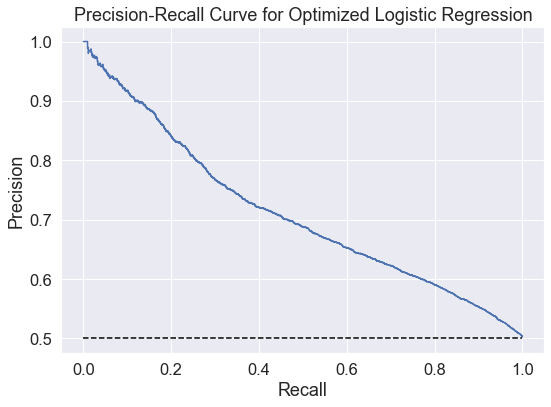

In [13]:
# plot precision - recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test[:,1])
plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.plot([0, 1], [0.5, 0.5], '--', color = 'black')
plt.title('Precision-Recall Curve for Optimized Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()

In [14]:
search.best_params_

{'preprocessor__num__strategy': 'median',
 'preprocessor__cat_num__strategy': 'most_frequent',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__n_estimators': 1500,
 'classifier__min_samples_split': 3,
 'classifier__min_samples_leaf': 5,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 20}

In [15]:
# Preprocessing for numerical data
numerical_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__num__strategy'])

# Preprocessing for binary data
binary_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__bin__strategy'])

# Preprocessing for categorical data encoded as numerical ID's
categorical_num_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__cat_num__strategy'])

# Preprocessing for categorical data
categorical_transformer_rev = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=search.best_params_['preprocessor__cat__imputer__strategy'])),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor_rev = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rev, numerical_columns),
        ('bin', binary_transformer_rev, binary_columns),
        ('cat_num', categorical_num_transformer_rev, cat_num_columns),
        ('cat', categorical_transformer_rev, categorical_columns)
    ])

# Bundle preprocessing and modeling code in a pipeline
pipeline_rev = Pipeline(steps=[('preprocessor', preprocessor_rev),
                              ('VarThresh', VarThresh)
                             ])

In [16]:
X_values = preprocessor_rev.fit_transform(X_train)
onehot_cat_columns = pipeline_rev.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_columns)
onehot = onehot_cat_columns.tolist() 
columns_tot = numerical_columns + binary_columns + cat_num_columns + onehot

feature_importance = pd.Series(data=opt_rf_clf.named_steps['classifier'].feature_importances_, index = np.array(columns_tot))

<AxesSubplot:>

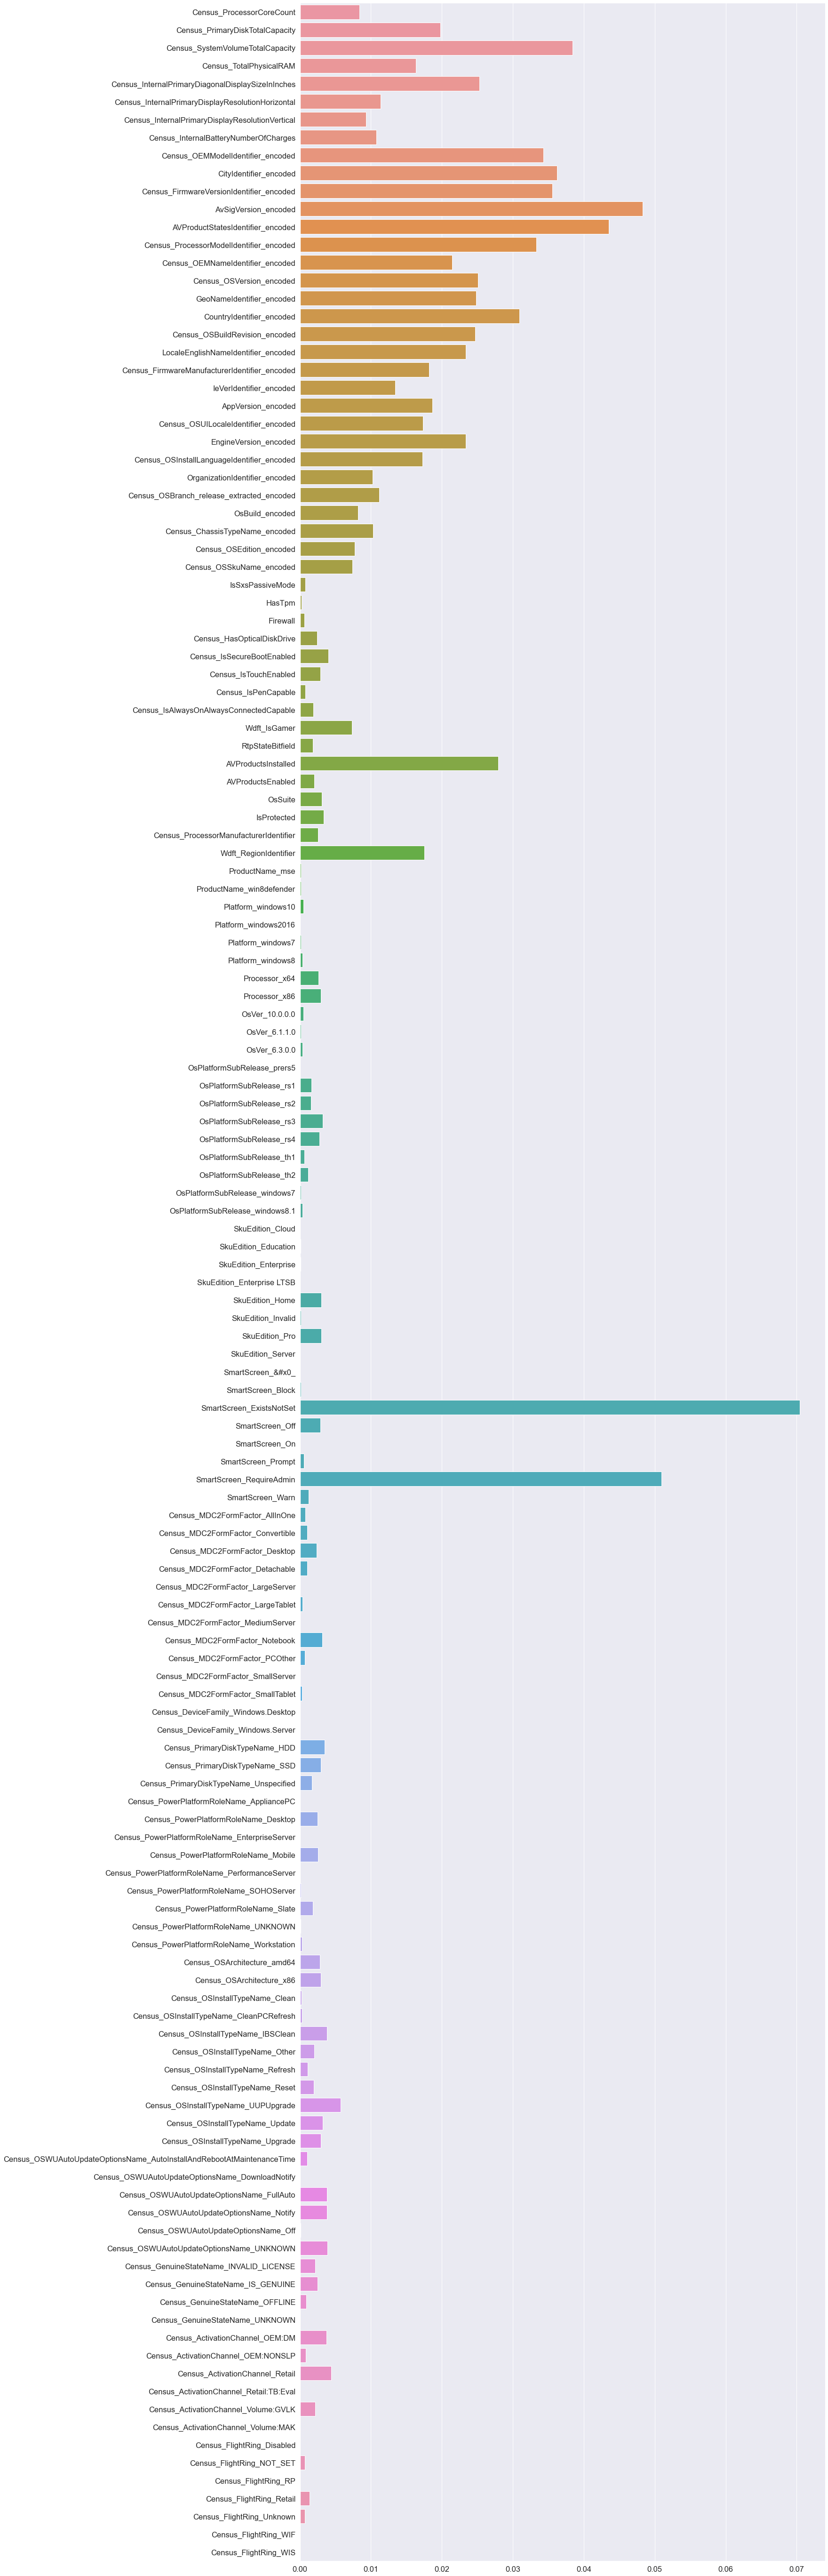

In [17]:
plt.figure(figsize=(20,100))
sns.barplot(y=feature_importance.index, 
            x=feature_importance.values, 
            orient='h')

In [18]:
std = np.std([tree.feature_importances_ for tree in opt_rf_clf.named_steps['classifier'].estimators_], axis=0)

<AxesSubplot:ylabel='index'>

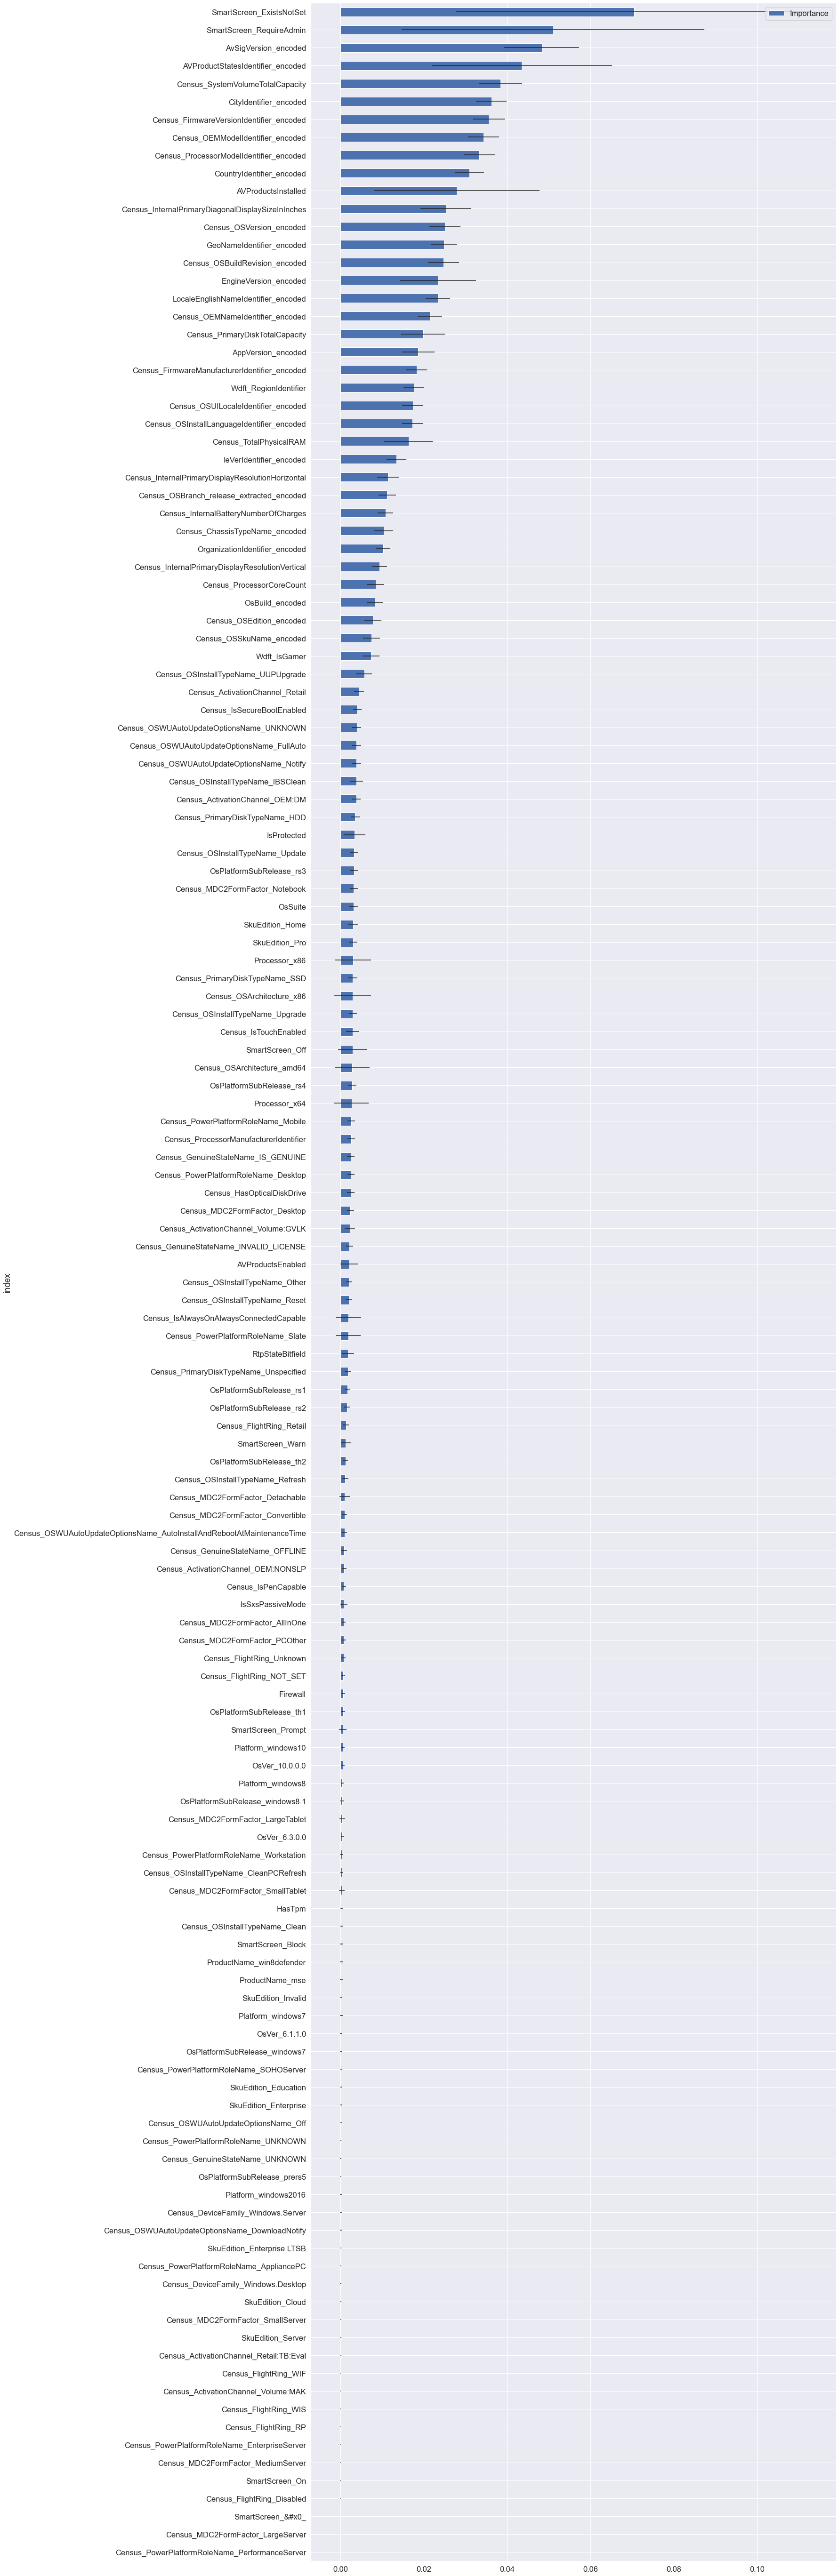

In [19]:
imp_df = pd.DataFrame(list(zip(feature_importance, std)), columns=['Importance', 'std'], index=feature_importance.index)
imp_df_sorted = imp_df.sort_values(by='Importance', ascending=True).reset_index()
imp_df_sorted.plot(kind='barh', y='Importance', x='index' , xerr='std', figsize=(20,100))

In [20]:
from sklearn.model_selection import learning_curve

opt_rf_clf_rev = opt_rf_clf
train_sizes, train_scores, test_scores = learning_curve(opt_rf_clf_rev, 
                                                        X_train, 
                                                        y_train, 
                                                        cv=5, 
                                                        scoring='roc_auc',
                                                        n_jobs=1,
                                                        train_sizes=np.linspace(.01, 1.0, 5), 
                                                        verbose=3)

[learning_curve] Training set sizes: [  570 14702 28833 42964 57096]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................., score=(train=0.998, test=0.627) total time=   4.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END ..................., score=(train=0.971, test=0.686) total time=  39.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.3s remaining:    0.0s


[CV] END ..................., score=(train=0.961, test=0.691) total time= 1.4min
[CV] END ..................., score=(train=0.945, test=0.693) total time= 2.2min
[CV] END ..................., score=(train=0.933, test=0.694) total time= 3.0min
[CV] END ..................., score=(train=0.992, test=0.640) total time=   5.1s
[CV] END ..................., score=(train=0.974, test=0.684) total time=  40.4s
[CV] END ..................., score=(train=0.961, test=0.691) total time= 1.4min
[CV] END ..................., score=(train=0.946, test=0.692) total time= 2.2min
[CV] END ..................., score=(train=0.935, test=0.694) total time= 3.0min
[CV] END ..................., score=(train=0.992, test=0.623) total time=   4.9s
[CV] END ..................., score=(train=0.974, test=0.681) total time=  39.8s
[CV] END ..................., score=(train=0.958, test=0.686) total time= 1.4min
[CV] END ..................., score=(train=0.943, test=0.688) total time= 2.2min
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 42.0min finished


Text(0.5, 1.0, 'Learning Curve (Random Forest)')

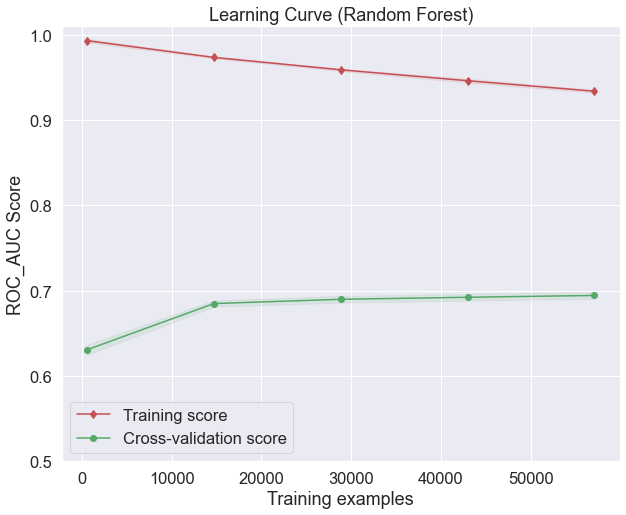

In [21]:
# Plot learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color='g')
plt.plot(train_sizes, train_scores_mean, 'd-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
plt.ylim(0.5, 1.01)
   
    
plt.legend(loc='best')
plt.xlabel('Training examples')
plt.ylabel('ROC_AUC Score')
plt.title('Learning Curve (Random Forest)')

In [22]:
X_train_full = [X_train, X_test]
y_train_full= [y_train, y_test]

X_train_full = pd.concat(X_train_full)
y_train_full = pd.concat(y_train_full)

X_train_full.shape, y_train_full.shape

((89214, 65), (89214,))

In [23]:
opt_rf_clf.fit(X_train_full, y_train_full)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Census_ProcessorCoreCount',
                                                   'Census_PrimaryDiskTotalCapacity',
                                                   'Census_SystemVolumeTotalCapacity',
                                                   'Census_TotalPhysicalRAM',
                                                   'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                   'Census_InternalPrimaryDisplayResolutionHorizontal',
                                                   'Census_InternalPr...
                                                   'Census_PowerPlatformRoleName',
                                                   'Census_OSArchitecture',
                                                   'Cen

In [24]:
with open('../data/processed/optimized_RF.pickle', 'wb') as handle:
    pickle.dump(opt_rf_clf, handle)